# D8 vs D-infinity Flow Routing Comparison

Side-by-side comparison of steady-state landscapes produced by D8 and D-infinity
(Tarboton 1997) flow routing. D-inf distributes flow to two receivers proportionally
based on a continuous flow angle from 8 triangular facets, eliminating D8's 45°
quantization.

Same physical parameters (K, D, U, m) as D8 — no re-optimization.

In [13]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path('../../src')))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterMathtext
from scipy.stats import linregress

import TopoAnalysis.dem as d

from models import advection_diffusion_model, partitioned_threshold_model
from models_dinf import advection_diffusion_model_dinf, partitioned_threshold_model_dinf
from dinf import compute_dinf_from_dem
from dinf import compute_dinf_flow_direction
from utils import load_tile_data, find_project_root
from analysis import slope_area_arrays_from_elevation, ks_from_loglog_fixed_theta
from plotting import set_nature_style

set_nature_style()

## Configuration

Pre-optimized parameters from the model-run notebooks.

In [2]:
ROOT = find_project_root()

CONFIGS = {
    'AP_tile1': {
        'base': str(ROOT / 'data' / 'AP' / 'tile1'),
        'region': 'AP',
        'U': 5.5e-5,
        'K': 4.0e-7,
        'D': 2.8e-3,
        'm': 0.562,
        'A_crit': 5000.0,  # approximate from optimization
        'label': 'Allegheny Plateau (tile 1)',
    },
    'GM_tile1': {
        'base': str(ROOT / 'data' / 'GM' / 'tile1'),
        'region': 'GM',
        'U': 1.47e-4,
        'K': 2.2e-5,
        'D': 1.0e-2,
        'm': 0.379,
        'A_crit': 5000.0,
        'label': 'Gabilan Mesa (tile 1)',
    },
}

print(f'Project root: {ROOT}')
print(f'Locations: {list(CONFIGS.keys())}')

Project root: /Users/scdobbs/Documents/GitHub/Manuscript_submission
Locations: ['AP_tile1', 'GM_tile1']


## Run Models

For each location: load data, compute D-inf routing, run D8 and D-inf AD models.

In [3]:
results = {}

for name, cfg in CONFIGS.items():
    print(f'\n=== {cfg["label"]} ===')
    
    # Load DEM, area, flow direction
    dem, area, fd = load_tile_data(cfg['base'], cfg['region'])
    print(f'  DEM shape: {dem._griddata.shape}')
    
    # Compute D-inf routing (using D8 fd for flat-cell fallback)
    angles, r_facet, facet_idx, A_dinf = compute_dinf_from_dem(dem, fd)
    print(f'  D-inf area range: [{np.nanmin(A_dinf):.1f}, {np.nanmax(A_dinf):.1f}]')
    print(f'  D8 area range:    [{np.nanmin(area._griddata):.1f}, {np.nanmax(area._griddata):.1f}]')
    
    m = cfg['m']
    U, K, D = cfg['U'], cfg['K'], cfg['D']
    
    # D8 AD model
    print('  Running D8 AD model...')
    solver_d8 = advection_diffusion_model(dem, area, fd, m)
    Z_d8 = solver_d8(U, K, D)
    
    # D-inf AD model
    print('  Running D-inf AD model...')
    solver_dinf = advection_diffusion_model_dinf(
        dem, area, fd, m, angles, r_facet, facet_idx, A_dinf,
    )
    Z_dinf = solver_dinf(U, K, D)
    
    # D8 partitioned threshold model
    print('  Running D8 partitioned threshold model...')
    pt_d8 = partitioned_threshold_model(dem, area, fd, m, U, K)
    Z_pt_d8, mask_pt_d8 = pt_d8(cfg['A_crit'], D)
    
    # D-inf partitioned threshold model
    print('  Running D-inf partitioned threshold model...')
    pt_dinf = partitioned_threshold_model_dinf(
        dem, area, fd, m, U, K, angles, r_facet, facet_idx, A_dinf,
    )
    Z_pt_dinf, mask_pt_dinf = pt_dinf(cfg['A_crit'], D)
    
    # Compute MSE vs observed
    Z_obs = dem._griddata
    valid = np.isfinite(Z_obs)
    mse_d8 = np.nanmean((Z_d8[valid] - Z_obs[valid]) ** 2)
    mse_dinf = np.nanmean((Z_dinf[valid] - Z_obs[valid]) ** 2)
    mse_pt_d8 = np.nanmean((Z_pt_d8[valid] - Z_obs[valid]) ** 2)
    mse_pt_dinf = np.nanmean((Z_pt_dinf[valid] - Z_obs[valid]) ** 2)
    
    print(f'  MSE (AD):  D8={mse_d8:.4e}  D-inf={mse_dinf:.4e}')
    print(f'  MSE (PT):  D8={mse_pt_d8:.4e}  D-inf={mse_pt_dinf:.4e}')
    
    results[name] = {
        'cfg': cfg,
        'dem': dem, 'area': area, 'fd': fd,
        'A_dinf': A_dinf,
        'Z_d8': Z_d8, 'Z_dinf': Z_dinf,
        'Z_pt_d8': Z_pt_d8, 'Z_pt_dinf': Z_pt_dinf,
        'mask_pt_d8': mask_pt_d8, 'mask_pt_dinf': mask_pt_dinf,
        'mse_d8': mse_d8, 'mse_dinf': mse_dinf,
        'mse_pt_d8': mse_pt_d8, 'mse_pt_dinf': mse_pt_dinf,
    }

print('\nDone.')


=== Allegheny Plateau (tile 1) ===
  DEM shape: (1015, 1015)
  D-inf area range: [1.0, 766473.3]
  D8 area range:    [1.0, 1115513.4]
  Running D8 AD model...
  Running D-inf AD model...
  Running D8 partitioned threshold model...
  Running D-inf partitioned threshold model...
  MSE (AD):  D8=6.9581e+05  D-inf=7.0133e+05
  MSE (PT):  D8=2.1950e+03  D-inf=3.7650e+06

=== Gabilan Mesa (tile 1) ===
  DEM shape: (1000, 1000)
  D-inf area range: [1.0, 247381.5]
  D8 area range:    [1.0, 1157840.0]
  Running D8 AD model...
  Running D-inf AD model...
  Running D8 partitioned threshold model...
  Running D-inf partitioned threshold model...
  MSE (AD):  D8=3.2286e+05  D-inf=3.1845e+05
  MSE (PT):  D8=7.9204e+02  D-inf=4.2395e+03

Done.


## Plot 1: 4-panel Elevation Comparison (AD Model)

Observed | D8 AD | D-inf AD | Difference (D-inf - D8)

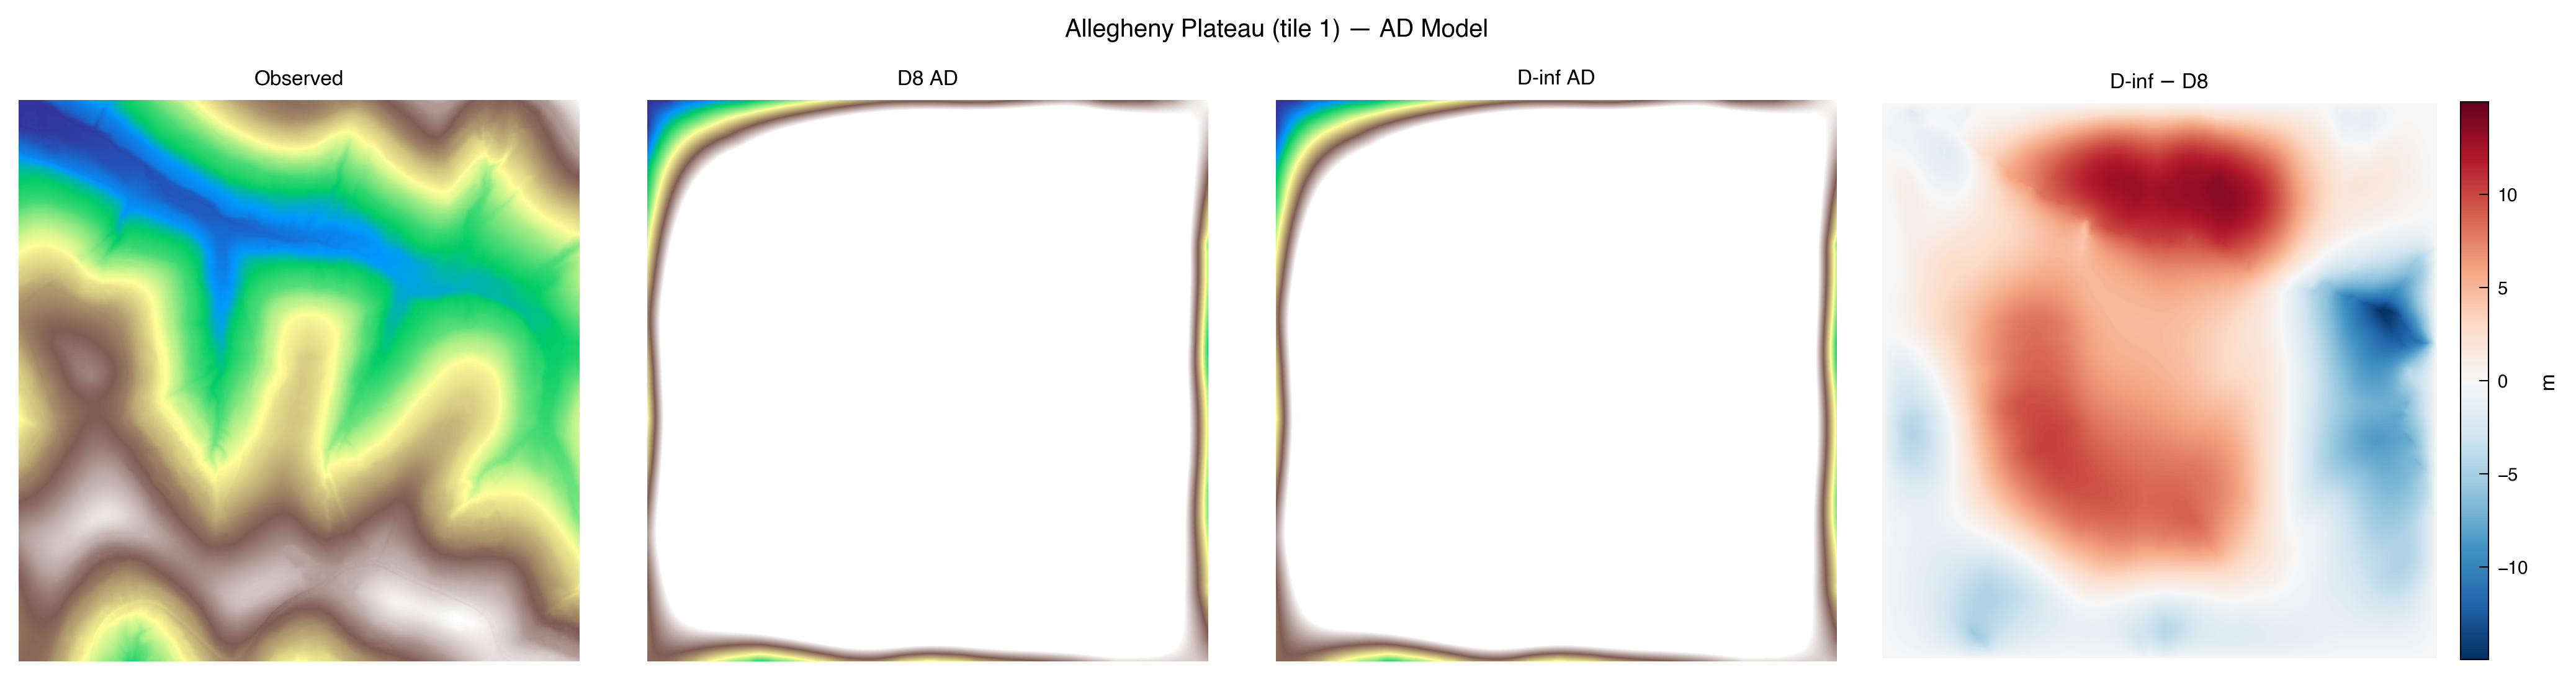

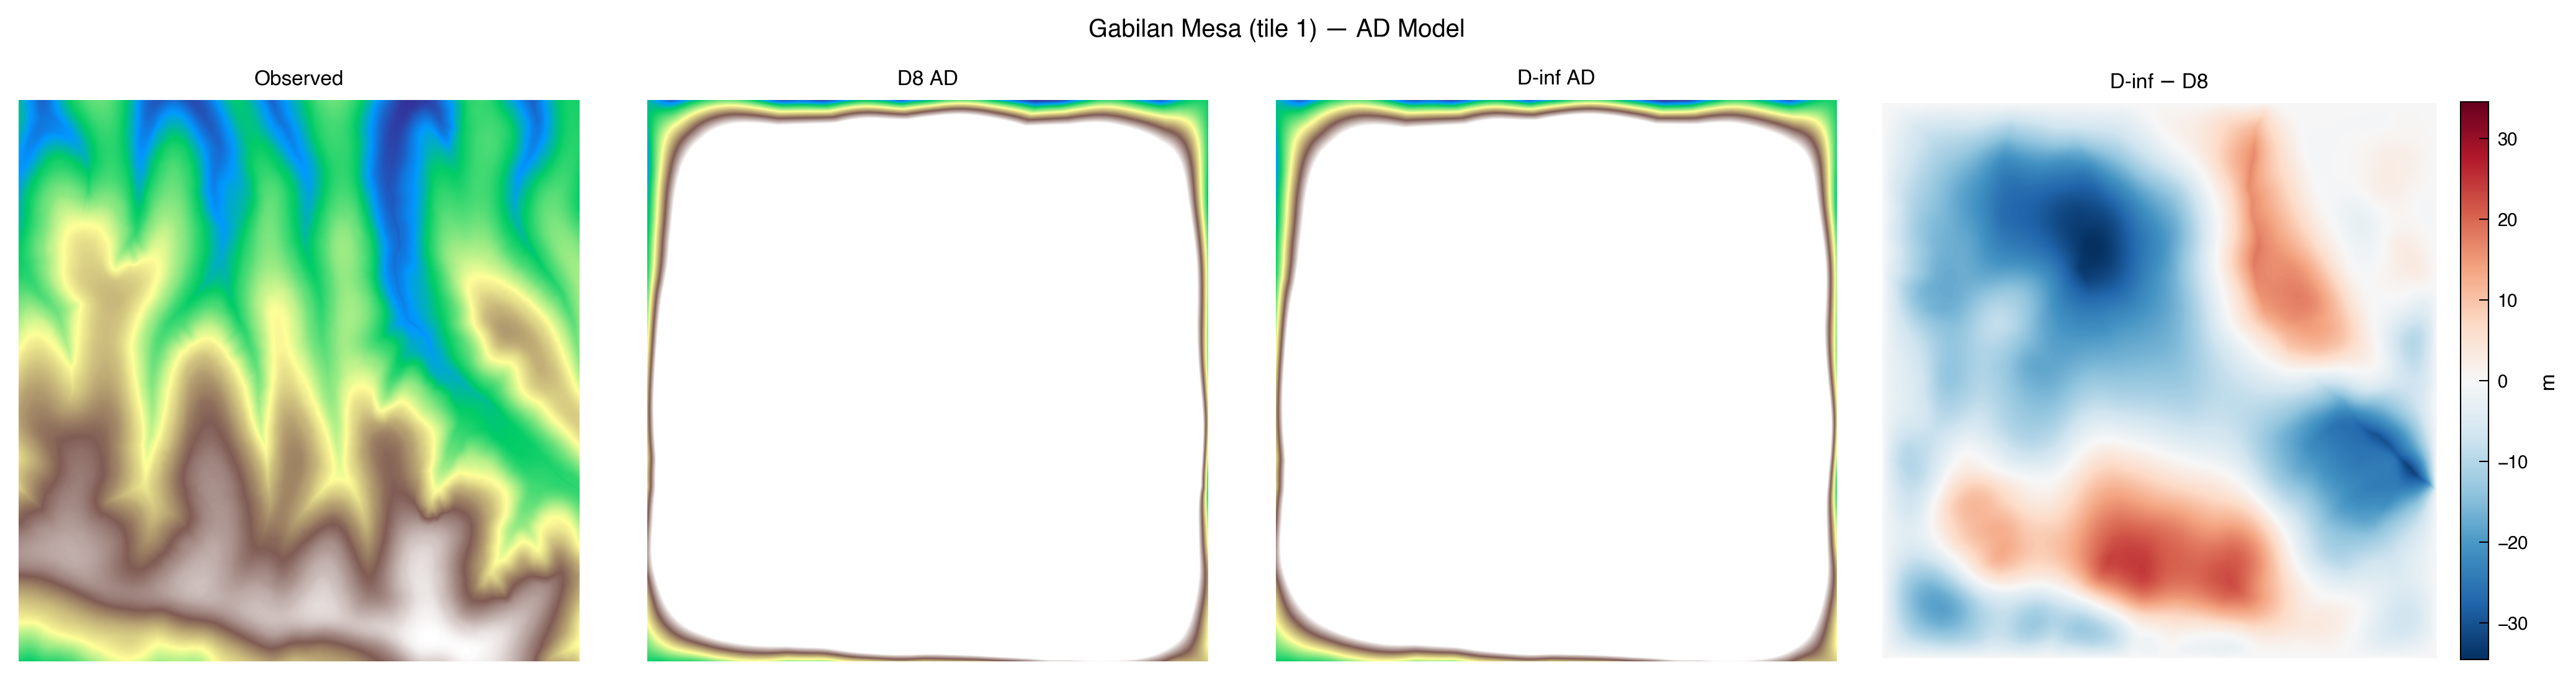

In [4]:
for name, res in results.items():
    cfg = res['cfg']
    Z_obs = res['dem']._griddata
    Z_d8 = res['Z_d8']
    Z_dinf = res['Z_dinf']
    diff = Z_dinf - Z_d8
    
    vmin = np.nanmin(Z_obs)
    vmax = np.nanmax(Z_obs)
    
    fig, axes = plt.subplots(1, 4, figsize=(14, 3.5),
                             gridspec_kw={'width_ratios': [1, 1, 1, 1]})
    
    for ax, Z, title in zip(axes[:3],
                             [Z_obs, Z_d8, Z_dinf],
                             ['Observed', 'D8 AD', 'D-inf AD']):
        im = ax.imshow(Z, cmap='terrain', origin='lower', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.axis('off')
    
    # Difference panel
    dmax = np.nanmax(np.abs(diff))
    im_diff = axes[3].imshow(diff, cmap='RdBu_r', origin='lower',
                              vmin=-dmax, vmax=dmax)
    axes[3].set_title('D-inf $-$ D8')
    axes[3].axis('off')
    fig.colorbar(im_diff, ax=axes[3], fraction=0.046, pad=0.04, label='m')
    
    fig.suptitle(f'{cfg["label"]} — AD Model', y=1.02)
    fig.tight_layout()
    plt.show()

## Plot 2: Log10 Area Comparison (D8 vs D-inf scatter)

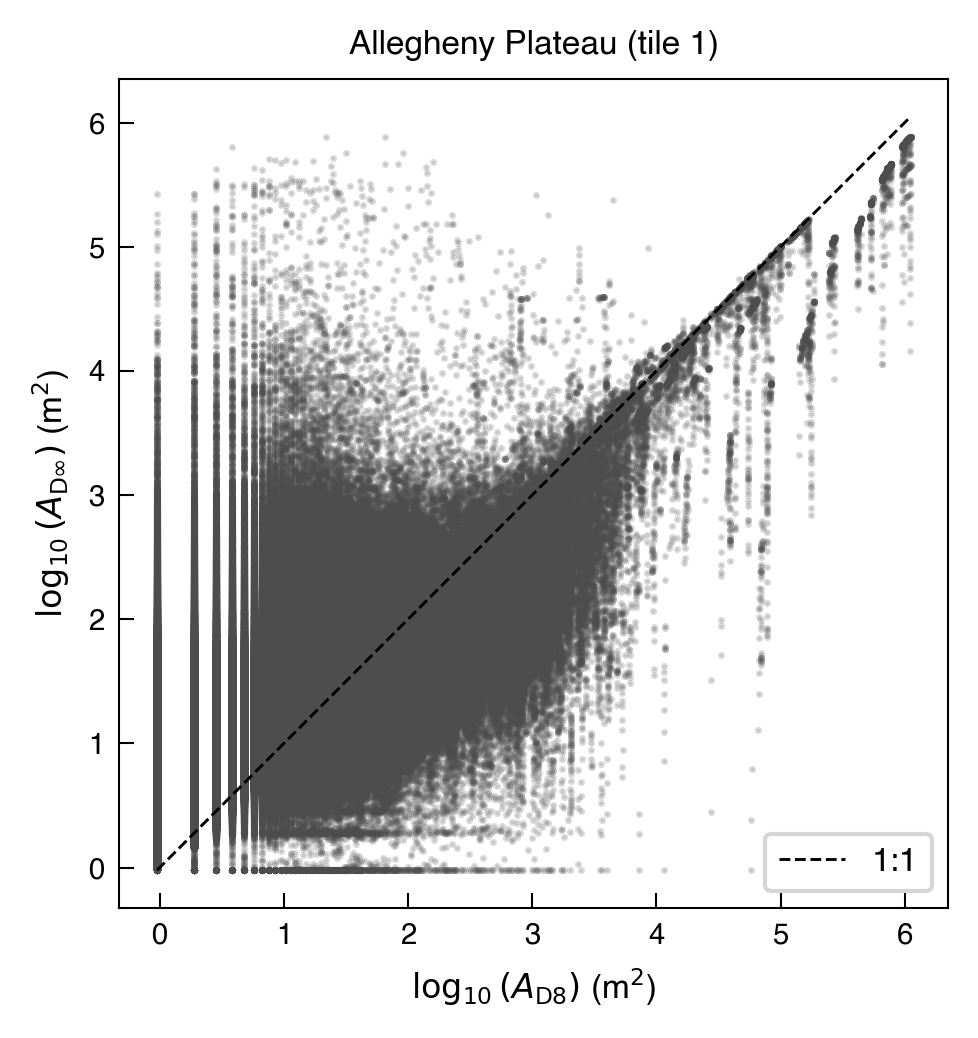

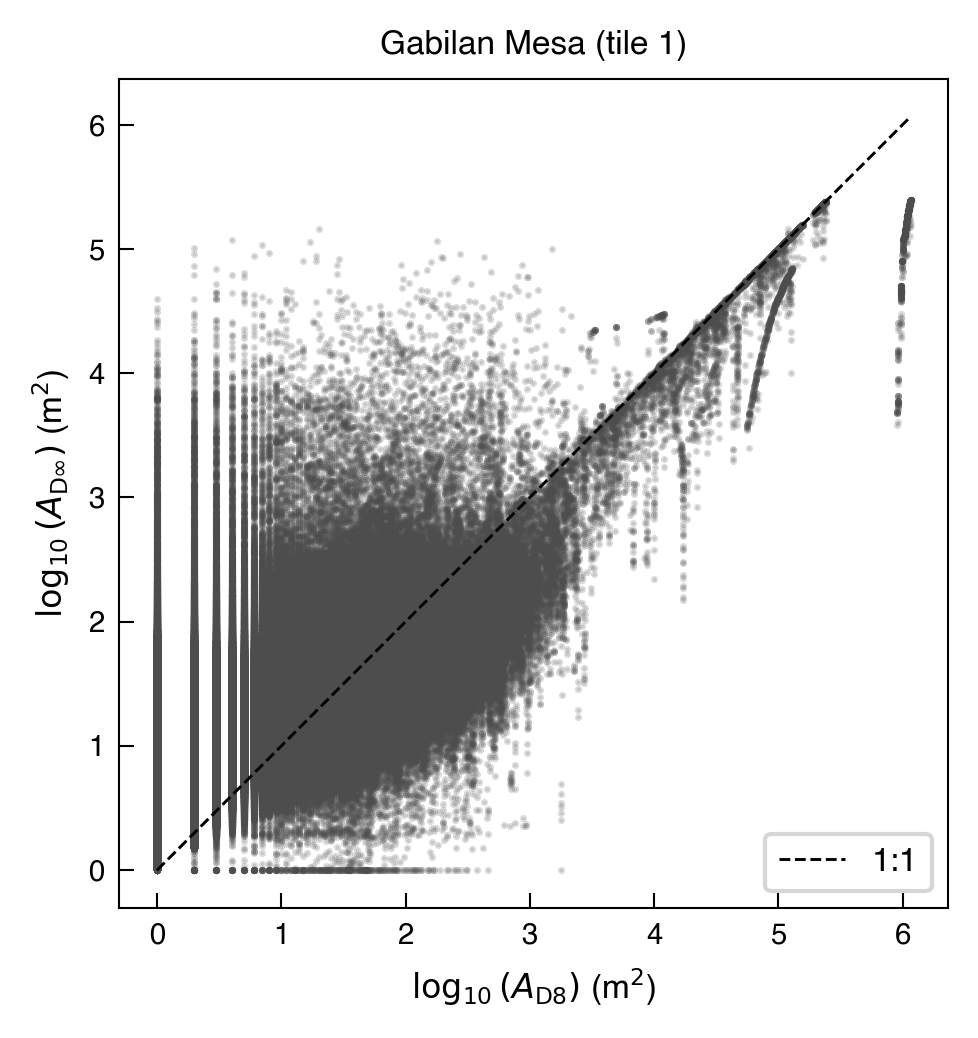

In [6]:
for name, res in results.items():
    cfg = res['cfg']
    A_d8 = res['area']._griddata
    A_dinf = res['A_dinf']
    
    valid = np.isfinite(A_d8) & np.isfinite(A_dinf) & (A_d8 > 0) & (A_dinf > 0)
    
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    ax.scatter(np.log10(A_d8[valid]), np.log10(A_dinf[valid]),
               s=0.5, alpha=0.2, c='0.3', rasterized=True)
    
    lims = [np.log10(max(np.nanmin(A_d8[valid]), np.nanmin(A_dinf[valid]))),
            np.log10(max(np.nanmax(A_d8[valid]), np.nanmax(A_dinf[valid])))]
    ax.plot(lims, lims, 'k--', lw=0.7, label='1:1')
    
    ax.set_xlabel(r'$\log_{10}(A_{\mathrm{D8}})$ (m$^2$)')
    ax.set_ylabel(r'$\log_{10}(A_{\mathrm{D}\infty})$ (m$^2$)')

    ax.set_title(cfg['label'])
    ax.set_aspect('equal')
    ax.legend(loc='lower right')
    
    fig.tight_layout()
    plt.show()

## Plot 3: Slope-Area Comparison

Observed, D8 model, and D-inf model overlaid.

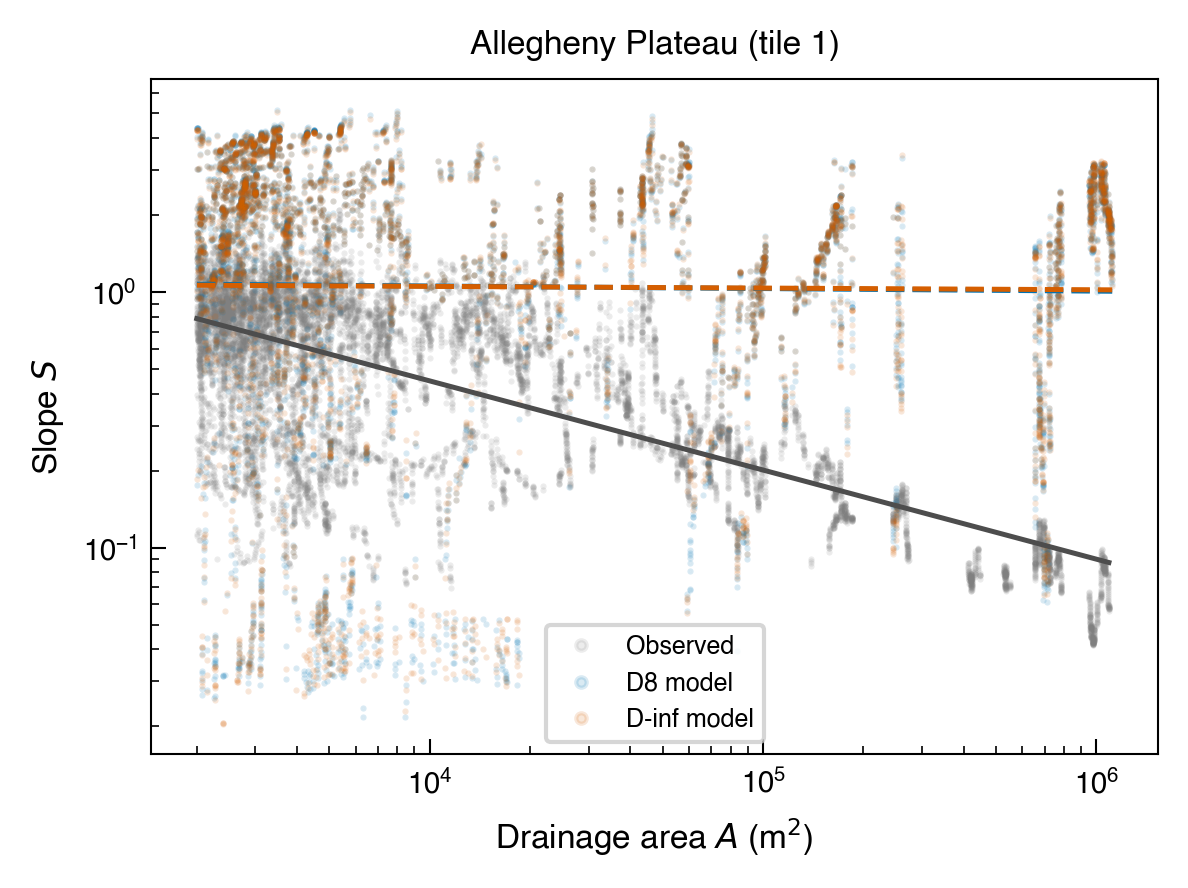

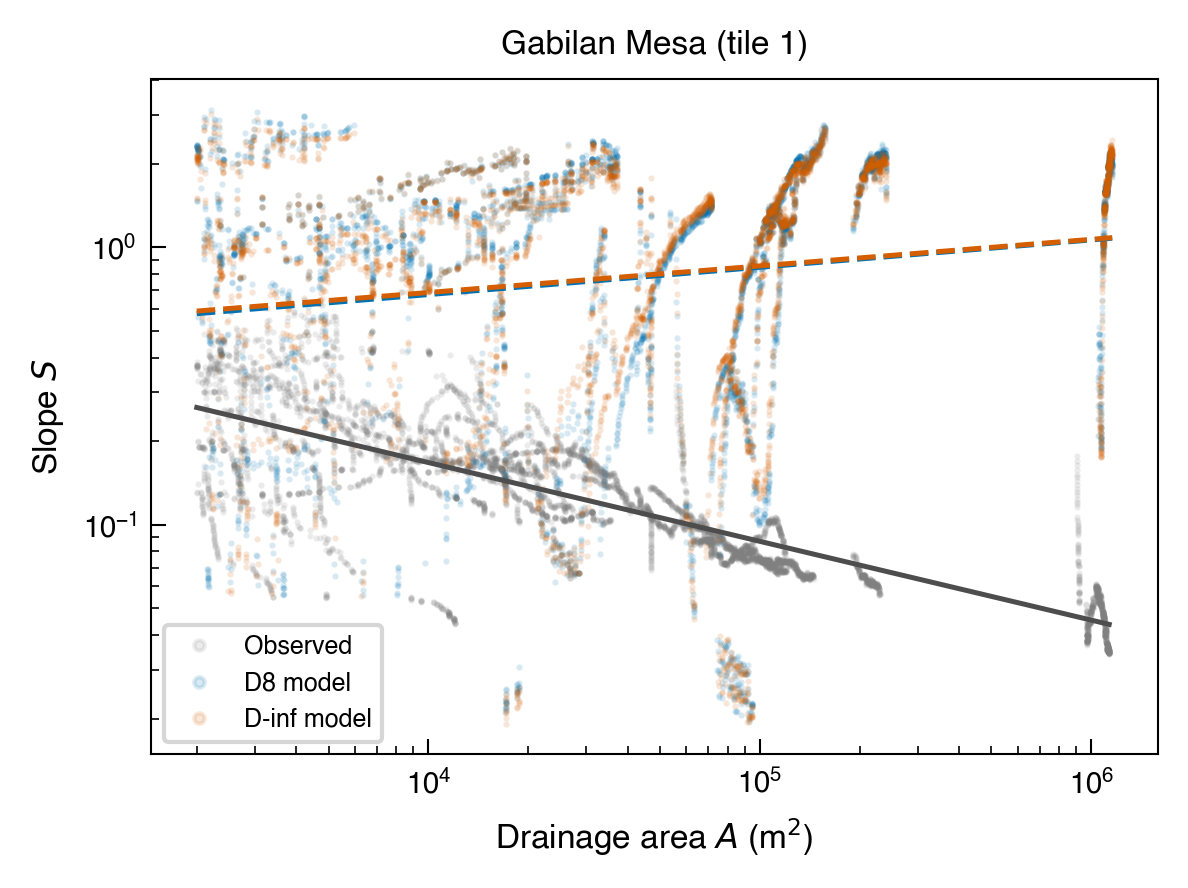

In [7]:
for name, res in results.items():
    cfg = res['cfg']
    dem = res['dem']
    area = res['area']
    fd = res['fd']
    m_exp = cfg['m']
    min_area = 2000.0
    
    # Observed S-A
    A_obs, S_obs = slope_area_arrays_from_elevation(dem, area, fd, min_area=min_area)
    
    # D8 model S-A
    dem_d8 = d.Elevation()
    dem_d8._griddata = res['Z_d8'].copy()
    dem_d8._georef_info = dem._georef_info
    dem_d8._nodata_value = np.nan
    A_d8, S_d8 = slope_area_arrays_from_elevation(dem_d8, area, fd, min_area=min_area)
    
    # D-inf model S-A
    dem_dinf = d.Elevation()
    dem_dinf._griddata = res['Z_dinf'].copy()
    dem_dinf._georef_info = dem._georef_info
    dem_dinf._nodata_value = np.nan
    A_dinf, S_dinf = slope_area_arrays_from_elevation(dem_dinf, area, fd, min_area=min_area)
    
    fig, ax = plt.subplots(figsize=(4, 3))
    
    ax.loglog(A_obs, S_obs, '.', ms=1, alpha=0.15, color='0.5', label='Observed')
    ax.loglog(A_d8, S_d8, '.', ms=1, alpha=0.15, color='#0072B2', label='D8 model')
    ax.loglog(A_dinf, S_dinf, '.', ms=1, alpha=0.15, color='#D55E00', label='D-inf model')
    
    # Best-fit lines
    for A_arr, S_arr, color, ls in [
        (A_obs, S_obs, '0.3', '-'),
        (A_d8, S_d8, '#0072B2', '--'),
        (A_dinf, S_dinf, '#D55E00', '--'),
    ]:
        if len(A_arr) > 10:
            slope_val, intercept, *_ = linregress(np.log10(A_arr), np.log10(S_arr))
            A_fit = np.logspace(np.log10(A_arr.min()), np.log10(A_arr.max()), 100)
            ax.plot(A_fit, 10**intercept * A_fit**slope_val, color=color, ls=ls, lw=1.2)
    
    ax.set_xlabel(r'Drainage area $A$ (m$^2$)')
    ax.set_ylabel(r'Slope $S$')
    ax.set_title(cfg['label'])
    ax.legend(markerscale=5, fontsize=6)
    
    fig.tight_layout()
    plt.show()

## Summary Table: MSE vs Observed

In [8]:
print(f'{"Location":<30s} {"Model":<20s} {"MSE (m²)":>12s}')
print('-' * 65)

for name, res in results.items():
    label = res['cfg']['label']
    print(f'{label:<30s} {"D8 AD":<20s} {res["mse_d8"]:>12.4e}')
    print(f'{"":<30s} {"D-inf AD":<20s} {res["mse_dinf"]:>12.4e}')
    print(f'{"":<30s} {"D8 PT":<20s} {res["mse_pt_d8"]:>12.4e}')
    print(f'{"":<30s} {"D-inf PT":<20s} {res["mse_pt_dinf"]:>12.4e}')
    print()

Location                       Model                    MSE (m²)
-----------------------------------------------------------------
Allegheny Plateau (tile 1)     D8 AD                  6.9581e+05
                               D-inf AD               7.0133e+05
                               D8 PT                  2.1950e+03
                               D-inf PT               3.7650e+06

Gabilan Mesa (tile 1)          D8 AD                  3.2286e+05
                               D-inf AD               3.1845e+05
                               D8 PT                  7.9204e+02
                               D-inf PT               4.2395e+03

